In [1]:
using Plots,SparseArrays,Arpack, LaTeXStrings,LinearAlgebra

In [51]:
r,s,t = 1.0,0.7, 0.0

V(x) = r*sin(4π*x) + s*sin(2π*x) +t*sin(π*x)
V′(x) = r*4π*cos(4π*x)+s*2π*cos(2π*x) + t*π*cos(π*x)
V′′(x) = -r*16π^2*sin(4π*x) - s*4π^2*r*sin(2π*x) - t*π^2*sin(π*x)

mu(x,β) = exp(-β*V(x))

plot(V,0,1,label="V")

N = 4000
Δx = 1/N
X = collect(range(0,1,N+1))
pop!(X)


@inline prev(i) = mod(i-1,1:N)
@inline next(i) = mod(i+1,1:N)


minima = [i for i=1:N if  V(X[prev(i)])>V(X[i])<V(X[next(i)])]
saddles = [i for i=1:N if V(X[prev(i)])<V(X[i])>V(X[next(i)])]

i0,i1 = minima
z0,z1 = saddles

ΔV₀₁ = min(V(X[z0])-V(X[i0]),V(X[z1])-V(X[i0]))
ΔV₁₀ = min(V(X[z0])-V(X[i1]),V(X[z1])-V(X[i1]))

killpoint = i1

lowest_saddle = (V(X[z0]) < V(X[z1])) ? z0 : z1
highest_saddle = (lowest_saddle == z0) ? z1 : z0

κ0 = -V′′(X[z0])
κ1 = -V′′(X[z1])

κ_high = -V′′(X[highest_saddle])
κ_low = -V′′(X[lowest_saddle])

V_high = V(X[highest_saddle])
V_low = V(X[lowest_saddle])

#Ωind = z0:z1 # bassin of i0
#Ωind = mod.(z1-N:z0,(1:N,)) # bassin of i1
# Ωind = [i for i=1:N if (X[z1]+0.1>X[i])&&(X[i]>X[z0]-0.1)] # domain encompassing bassin of i0
# Ω = X[Ωind]

println("--- Values of V ---")

println("\t--- Minima")
println("\t\t x0: ", V(X[i0]))
println("\t\t x1: ", V(X[i1]),"\n")

println("\t--- Saddles")
println("\t\t z0: ", V(X[z0]))
println("\t\t z1: ", V(X[z1]),"\n")

println("\t--- Potential barriers ---")
println("\t\t x0 → x1: ", ΔV₀₁)
println("\t\t x1 → x0: ", ΔV₁₀,"\n")


println("--- Values of V′′")

println("\t--- Minima")
println("\t\t x0: ", V′′(X[i0]))
println("\t\t x1: ", V′′(X[i1]),"\n")

println("\t--- Saddles")
println("\t\t z0: ", V′′(X[z0]))
println("\t\t z1: ", V′′(X[z1]))

βmax = round(20/ΔV₀₁,digits=2) # empirical -- otherwise floating point errors become an issue
βrange = 1:0.1:βmax 

--- Values of V ---
	--- Minima
		 x0: -0.5399995279488243
		 x1: -1.5222180470755782

	--- Saddles
		 z0: 1.5222180470755782
		 z1: 0.5399995279488242

	--- Potential barriers ---
		 x0 → x1: 1.0799990558976487
		 x1 → x0: 2.0622175750244023

--- Values of V′′
	--- Minima
		 x0: 135.0509523084653
		 x1: 175.67770817206954

	--- Saddles
		 z0: -175.67770817206954
		 z1: -135.05095230846533


1.0:0.1:18.5

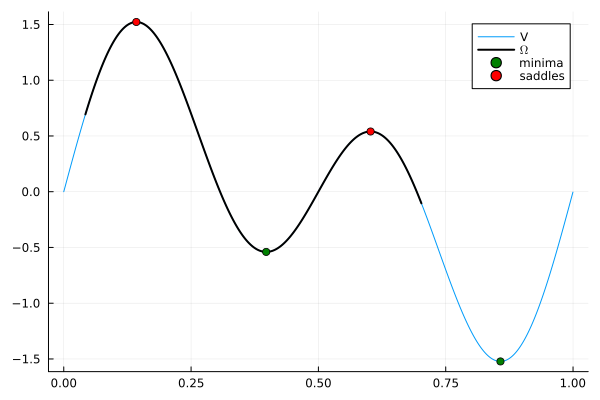

In [52]:
Ωind = [i for i=1:N if (X[z1]+0.1>X[i])&&(X[i]>X[z0]-0.1)]
Ω = X[Ωind]

plot(X,V.(X),label="V")
plot!(Ω,V.(Ω),color=:black,linewidth=2,label=L"\Omega")
scatter!(X[minima],V.(X[minima]),color=:green,label="minima")
scatter!(X[saddles],V.(X[saddles]),color=:red,label="saddles")

In [53]:
function eigenproblem(β,N,Ωind; witten=false)

    rate(i,j) = exp(-β*(V(X[j])-V(X[i]))/2)
    rate_witten(i,j) = exp(-β*(V(X[j])-V(X[i])))

    rows = vcat(([i,i,i] for i=1:N)...)
    cols = vcat(([i,prev(i),next(i)] for i=1:N)...)

    fac = N^2/β # scaling constant -- for consistent approximation of -L = ∇V⋅∇ - β⁻¹Δ

    if !witten
        vals = vcat((fac*[rate(i,prev(i))+rate(i,next(i)),-rate(i,prev(i)),-rate(i,next(i))] for i=1:N)...) 
    else
        vals = vcat((fac*[rate(i,prev(i))+rate(i,next(i)),-rate_witten(i,prev(i)),-rate_witten(i,next(i))] for i=1:N)...) # exp(-βV/2)L exp(βV/2) -- appears numerically less stable for λ₂
    end

    L = sparse(rows,cols,vals)

    if !witten
        #B = spdiagm(@. exp(-β* V(X)))
        #M = B * L
        # display(M)
        # @show issymmetric(M)
        # Mred = M[Ωind,Ωind]
        #λs,us = eigs(Mred,B[Ωind,Ωind],sigma=0,nev=3,which=:LR,tol=1e-22)
        λs,us = eigs(L[Ωind,Ωind],sigma=0,nev=3,which=:LR,tol=1e-22)
    else
        B = nothing
        # M = L
        # display(M)
        # @show issymmetric(M)
        # Mred = L[Ωind,Ωind]
        λs,us = eigs(L[Ωind,Ωind],sigma=0,nev=3,which=:LR,tol=1e-22)
    end



    λs = real.(λs)
    us = real.(us)

    return λs[1],λs[2],us[:,1],us[:,2],L
end

eigenproblem (generic function with 1 method)

In [54]:
β = 10.0

λ1,λ2,u1,u2,L = eigenproblem(β,N,Ωind; witten=false)

(0.0004219826345904856, 118.04453671104261, [2.4737476719892575e-8, 5.042399289962235e-8, 7.70944924619736e-8, 1.0478513965075139e-7, 1.335333587433392e-7, 1.6337787495113217e-7, 1.9435875651353677e-7, 2.2651745801300932e-7, 2.598968649850178e-7, 2.945413397823087e-7  …  1.5625757625565773e-6, 1.3851818474882018e-6, 1.2128335317912233e-6, 1.045394201946267e-6, 8.827306945595019e-7, 7.247132177761732e-7, 5.71215274227908e-7, 4.221135854306119e-7, 2.7728801770036535e-7, 1.3662150945759153e-7], [-4.2250511784643047e-8, -8.611878142122229e-8, -1.3166105002090115e-7, -1.7893541125477686e-7, -2.280018362847854e-7, -2.7892224597665546e-7, -3.3176055789018113e-7, -3.865827078636177e-7, -4.4345678779645467e-7, -5.024530279244697e-7  …  3.1028334720754804e-5, 2.751220509068503e-5, 2.4094083731175293e-5, 2.077156841449379e-5, 1.7542309763954778e-5, 1.4404010308537813e-5, 1.135442346652621e-5, 8.391352670772344e-6, 5.51265029597855e-6, 2.7162168492202247e-6], sparse([1, 2, 4000, 1, 2, 3, 2, 3, 4, 

In [60]:
using Optim

ε = 0.1
phi(x) = sqrt(ε^2 + x^2) - ε # soft abs
phi′(x) = x / sqrt(ε^2 + x^2)

function fg!(F,G,x)
    alpha = phi.(x)
    A = spdiagm(alpha)
    M = L[Ωind,Ωind] + A

    λs,us = eigs(M,sigma=0,nev=2,which=:LR,tol=1e-22)
    _,vs = eigs(M',sigma=0,nev=2,which=:LR,tol=1e-22) # left eigenvectors

    λ1,λ2 = real.(λs)
    u1,u2 = eachcol(real.(us))
    v1,v2 = eachcol(real.(vs))

    ∂λ1 = (v1 .* u1)/(v1'u1)
    ∂λ2 = (v2 .* u2)/(v2'u2)


    if G !== nothing
        G .= phi′.(x) .* (∂λ1/λ1 - ∂λ2/λ2)
    end

    if F!==nothing
        return log(λ1) - log(λ2)
    end
end

x0 = ones(length(Ω))

results = optimize(Optim.only_fg!(fg!),x0,GradientDescent(),Optim.Options(show_trace=true,show_every=10))

for i=1:5
    results = optimize(Optim.only_fg!(fg!),results.minimizer,GradientDescent(),Optim.Options(show_trace=true,show_every=20))
end


Iter     Function value   Gradient norm 
     0    -4.878067e+00     3.950791e-03
 * time: 7.581710815429688e-5


    10    -8.152639e+00     3.295675e-02
 * time: 2.8311638832092285


    20    -8.586856e+00     3.807572e-02
 * time: 4.946004867553711


    30    -8.890271e+00     4.036729e-02
 * time: 6.855048894882202


    40    -9.122319e+00     4.297997e-02
 * time: 9.879228830337524


    50    -9.309649e+00     4.521421e-02
 * time: 13.926081895828247


    60    -9.466288e+00     4.714602e-02
 * time: 17.472510814666748


    70    -9.600563e+00     4.883520e-02
 * time: 21.06558895111084


    80    -9.717822e+00     5.032719e-02
 * time: 24.855037927627563


    90    -9.821705e+00     5.165597e-02
 * time: 27.810025930404663


   100    -9.914802e+00     5.284737e-02
 * time: 31.03083300590515


   110    -9.999019e+00     5.392149e-02
 * time: 34.84086894989014


   120    -1.007580e+01     5.489426e-02
 * time: 37.92559790611267


   130    -1.014628e+01     5.577855e-02
 * time: 41.25361490249634


   140    -1.021133e+01     5.658493e-02
 * time: 44.7431378364563


   150    -1.027166e+01     5.732218e-02
 * time: 47.81602382659912


   160    -1.032788e+01     5.799770e-02
 * time: 50.75584697723389


   170    -1.038045e+01     5.861778e-02
 * time: 54.45523977279663


   180    -1.042977e+01     5.918780e-02
 * time: 58.02093696594238


   190    -1.047620e+01     5.971245e-02
 * time: 61.48176097869873


   200    -1.052002e+01     6.019578e-02
 * time: 64.9256489276886


   210    -1.056148e+01     6.064136e-02
 * time: 67.72742986679077


   220    -1.060079e+01     6.105234e-02
 * time: 70.78068494796753


   230    -1.063815e+01     6.143151e-02
 * time: 74.261403799057


   240    -1.067372e+01     6.178135e-02
 * time: 77.35040187835693


   250    -1.070764e+01     6.210410e-02
 * time: 80.54260993003845


   260    -1.074004e+01     6.240174e-02
 * time: 83.5471978187561


   270    -1.077105e+01     6.267609e-02
 * time: 86.93063592910767


   280    -1.080075e+01     6.292877e-02
 * time: 89.748783826828


   290    -1.082924e+01     6.316128e-02
 * time: 93.1472339630127


   300    -1.085660e+01     6.337497e-02
 * time: 95.84690880775452


   310    -1.088292e+01     6.357106e-02
 * time: 98.7397358417511


   320    -1.090824e+01     6.375069e-02
 * time: 101.74828290939331


   330    -1.093265e+01     6.391489e-02
 * time: 105.17905783653259


   340    -1.095619e+01     6.406463e-02
 * time: 108.36977791786194


   350    -1.097891e+01     6.420077e-02
 * time: 111.75345587730408


   360    -1.100087e+01     6.432414e-02
 * time: 115.35112690925598


   370    -1.102210e+01     6.443548e-02
 * time: 118.64274883270264


   380    -1.104264e+01     6.453550e-02
 * time: 121.75728297233582


   390    -1.106253e+01     6.462483e-02
 * time: 124.57405185699463


   400    -1.108181e+01     6.470409e-02
 * time: 127.25303196907043


   410    -1.110050e+01     6.477383e-02
 * time: 130.13602995872498


   420    -1.111864e+01     6.483457e-02
 * time: 132.8205897808075


   430    -1.113626e+01     6.488682e-02
 * time: 136.02630591392517


   440    -1.115337e+01     6.493101e-02
 * time: 138.88814282417297


   450    -1.117000e+01     6.496758e-02
 * time: 141.78920793533325


   460    -1.118617e+01     6.499694e-02
 * time: 145.1135687828064


   470    -1.120190e+01     6.501945e-02
 * time: 148.29751896858215


   480    -1.121722e+01     6.503547e-02
 * time: 151.03095293045044


   490    -1.123214e+01     6.504533e-02
 * time: 154.1659848690033


   500    -1.124668e+01     6.504935e-02
 * time: 156.92876982688904


   510    -1.126085e+01     6.504782e-02
 * time: 159.7499439716339


   520    -1.127467e+01     6.504102e-02
 * time: 162.45170998573303


   530    -1.128815e+01     6.502921e-02
 * time: 165.58946299552917


   540    -1.130131e+01     6.501265e-02
 * time: 168.45190978050232


   550    -1.131416e+01     6.499155e-02
 * time: 171.6905698776245


   560    -1.132671e+01     6.496615e-02
 * time: 175.2693099975586


   570    -1.133897e+01     6.493665e-02
 * time: 178.59386897087097


   580    -1.135095e+01     6.490325e-02
 * time: 181.55114579200745


   590    -1.136267e+01     6.486614e-02
 * time: 185.4666509628296


   600    -1.137413e+01     6.482550e-02
 * time: 188.6596839427948


   610    -1.138533e+01     6.478151e-02
 * time: 191.61497688293457


   620    -1.139630e+01     6.473430e-02
 * time: 195.38789296150208


   630    -1.140704e+01     6.468405e-02
 * time: 198.88998889923096


   640    -1.141756e+01     6.463090e-02
 * time: 202.1570529937744


   650    -1.142785e+01     6.457498e-02
 * time: 205.52344298362732


   660    -1.143794e+01     6.451642e-02
 * time: 208.36011600494385


   670    -1.144783e+01     6.445535e-02
 * time: 211.4082338809967


   680    -1.145752e+01     6.439189e-02
 * time: 214.1069939136505


   690    -1.146702e+01     6.432616e-02
 * time: 216.81399297714233


   700    -1.147634e+01     6.425825e-02
 * time: 219.48981881141663


   710    -1.148548e+01     6.418828e-02
 * time: 222.2143428325653


   720    -1.149445e+01     6.411634e-02
 * time: 224.8636019229889


   730    -1.150324e+01     6.404253e-02
 * time: 228.19927287101746


   740    -1.151188e+01     6.396693e-02
 * time: 231.00122785568237


   750    -1.152036e+01     6.388963e-02
 * time: 233.67061686515808


   760    -1.152869e+01     6.381071e-02
 * time: 236.34048700332642


   770    -1.153686e+01     6.373025e-02
 * time: 238.9833378791809


   780    -1.154490e+01     6.364834e-02
 * time: 241.77750396728516


   790    -1.155279e+01     6.356502e-02
 * time: 244.96428680419922


   800    -1.156055e+01     6.348038e-02
 * time: 247.78360199928284


   810    -1.156817e+01     6.339447e-02
 * time: 250.28810286521912


   820    -1.157566e+01     6.330737e-02
 * time: 252.81514596939087


   830    -1.158303e+01     6.321913e-02
 * time: 255.66280388832092


   840    -1.159028e+01     6.312981e-02
 * time: 258.2497179508209


   850    -1.159741e+01     6.303946e-02
 * time: 260.65105390548706


   860    -1.160442e+01     6.294813e-02
 * time: 263.5640878677368


   870    -1.161132e+01     6.285589e-02
 * time: 266.0415267944336


   880    -1.161810e+01     6.276277e-02
 * time: 269.28169798851013


   890    -1.162478e+01     6.266882e-02
 * time: 271.88577580451965


   900    -1.163136e+01     6.257408e-02
 * time: 274.4382469654083


   910    -1.163783e+01     6.247860e-02
 * time: 277.0308768749237


   920    -1.164421e+01     6.238242e-02
 * time: 279.52880597114563


   930    -1.165048e+01     6.228558e-02
 * time: 282.0986669063568


   940    -1.165667e+01     6.218811e-02
 * time: 284.64860486984253


   950    -1.166276e+01     6.209006e-02
 * time: 287.16739892959595


   960    -1.166876e+01     6.199145e-02
 * time: 289.6399998664856


   970    -1.167467e+01     6.189233e-02
 * time: 292.20485281944275


   980    -1.168049e+01     6.179271e-02
 * time: 294.68661880493164


   990    -1.168623e+01     6.169264e-02
 * time: 297.198734998703


  1000    -1.169189e+01     6.159214e-02
 * time: 299.58955788612366


Iter     Function value   Gradient norm 
     0    -1.169189e+01     6.159214e-02
 * time: 0.00010395050048828125


    20    -1.170358e+01     2.678505e-02
 * time: 4.751000881195068


    40    -1.171485e+01     2.717154e-02
 * time: 9.498127937316895


    60    -1.172567e+01     2.741117e-02
 * time: 14.397778987884521


    80    -1.173609e+01     2.755777e-02
 * time: 19.38968801498413


   100    -1.174618e+01     2.764174e-02
 * time: 24.39325189590454


   120    -1.175595e+01     2.768177e-02
 * time: 29.37252402305603


   140    -1.176544e+01     2.769010e-02
 * time: 34.90499496459961


   160    -1.177466e+01     2.767502e-02
 * time: 40.37570095062256


   180    -1.178362e+01     2.764240e-02
 * time: 46.21623682975769


   200    -1.179236e+01     2.759644e-02
 * time: 52.365864992141724


   220    -1.180087e+01     2.754024e-02
 * time: 58.06518888473511


   240    -1.180916e+01     2.747612e-02
 * time: 64.63088297843933


   260    -1.181726e+01     2.740583e-02
 * time: 71.3006980419159


   280    -1.182516e+01     2.733071e-02
 * time: 77.66842889785767


   300    -1.183287e+01     2.725179e-02
 * time: 84.04766392707825


   320    -1.184041e+01     2.716991e-02
 * time: 89.7998719215393


   340    -1.184777e+01     2.708569e-02
 * time: 94.81829404830933


   360    -1.185497e+01     2.699965e-02
 * time: 99.66258001327515


   380    -1.186200e+01     2.691219e-02
 * time: 104.74949097633362


   400    -1.186889e+01     2.682364e-02
 * time: 109.57475090026855


   420    -1.187563e+01     2.673426e-02
 * time: 116.05569386482239


   440    -1.188222e+01     2.664428e-02
 * time: 123.0013279914856


   460    -1.188868e+01     2.655389e-02
 * time: 130.42193698883057


   480    -1.189500e+01     2.646320e-02
 * time: 136.87637305259705


   500    -1.190119e+01     2.637235e-02
 * time: 143.75997304916382


   520    -1.190726e+01     2.628145e-02
 * time: 150.95927691459656


   540    -1.191320e+01     2.619058e-02
 * time: 157.62211394309998


   560    -1.191903e+01     2.609980e-02
 * time: 164.33198404312134


   580    -1.192475e+01     2.600918e-02
 * time: 171.2280788421631


   600    -1.193035e+01     2.591876e-02
 * time: 177.7088348865509


   620    -1.193585e+01     2.582861e-02
 * time: 184.3961329460144


   640    -1.194124e+01     2.573873e-02
 * time: 191.3379979133606


   660    -1.194654e+01     2.564917e-02
 * time: 197.77772498130798


   680    -1.195173e+01     2.555996e-02
 * time: 204.40719604492188


   700    -1.195683e+01     2.547111e-02
 * time: 209.81872487068176


   720    -1.196184e+01     2.538265e-02
 * time: 216.35882592201233


   740    -1.196676e+01     2.529460e-02
 * time: 221.96686482429504


   760    -1.197159e+01     2.520697e-02
 * time: 226.89001393318176


   780    -1.197633e+01     2.511977e-02
 * time: 231.8038148880005


   800    -1.198099e+01     2.503301e-02
 * time: 236.78693985939026


   820    -1.198558e+01     2.494670e-02
 * time: 241.94006204605103


   840    -1.199008e+01     2.486085e-02
 * time: 249.11304092407227


   860    -1.199451e+01     2.477547e-02
 * time: 255.31003999710083


   880    -1.199886e+01     2.469055e-02
 * time: 261.36728596687317


   900    -1.200314e+01     2.460611e-02
 * time: 267.00297594070435


   920    -1.200735e+01     2.452214e-02
 * time: 272.4935760498047


   940    -1.201149e+01     2.443866e-02
 * time: 277.5098888874054


   960    -1.201557e+01     2.435566e-02
 * time: 283.2377059459686


   980    -1.201957e+01     2.427315e-02
 * time: 288.1489448547363


  1000    -1.202352e+01     2.419112e-02
 * time: 294.2974739074707


Iter     Function value   Gradient norm 
     0    -1.202352e+01     2.419112e-02
 * time: 8.296966552734375e-5


    20    -1.202765e+01     2.229879e-02
 * time: 5.847095966339111


    40    -1.203169e+01     2.239993e-02
 * time: 10.909308910369873


    60    -1.203565e+01     2.247584e-02
 * time: 15.999267816543579


    80    -1.203952e+01     2.253137e-02
 * time: 21.103155851364136


   100    -1.204331e+01     2.257022e-02
 * time: 26.424635887145996


   120    -1.204702e+01     2.259521e-02
 * time: 31.33181595802307


   140    -1.205067e+01     2.260861e-02
 * time: 36.22639203071594


   160    -1.205424e+01     2.261219e-02
 * time: 41.134466886520386


   180    -1.205776e+01     2.260742e-02
 * time: 46.25906491279602


   200    -1.206121e+01     2.259550e-02
 * time: 51.56958198547363


   220    -1.206460e+01     2.257742e-02
 * time: 58.63557291030884


   240    -1.206794e+01     2.255404e-02
 * time: 65.52637696266174


   260    -1.207123e+01     2.252604e-02
 * time: 72.60550594329834


   280    -1.207446e+01     2.249403e-02
 * time: 79.69728493690491


   300    -1.207764e+01     2.245853e-02
 * time: 86.5803689956665


   320    -1.208077e+01     2.241996e-02
 * time: 93.420569896698


   340    -1.208385e+01     2.237873e-02
 * time: 100.7070848941803


   360    -1.208689e+01     2.233516e-02
 * time: 107.68055295944214


   380    -1.208989e+01     2.228953e-02
 * time: 114.39666390419006


   400    -1.209284e+01     2.224211e-02
 * time: 121.76392102241516


   420    -1.209574e+01     2.219311e-02
 * time: 128.9386749267578


   440    -1.209861e+01     2.214273e-02
 * time: 135.57084488868713


   460    -1.210144e+01     2.209114e-02
 * time: 142.9231059551239


   480    -1.210422e+01     2.203850e-02
 * time: 149.51029086112976


   500    -1.210697e+01     2.198494e-02
 * time: 156.3932340145111


   520    -1.210968e+01     2.193059e-02
 * time: 163.31173181533813


   540    -1.211236e+01     2.187555e-02
 * time: 170.18228888511658


   560    -1.211500e+01     2.181991e-02
 * time: 177.0985939502716


   580    -1.211760e+01     2.176377e-02
 * time: 183.91494798660278


   600    -1.212017e+01     2.170720e-02
 * time: 190.91721987724304


   620    -1.212271e+01     2.165026e-02
 * time: 198.14957189559937


   640    -1.212522e+01     2.159302e-02
 * time: 204.48305583000183


   660    -1.212769e+01     2.153555e-02
 * time: 209.74676990509033


   680    -1.213013e+01     2.147788e-02
 * time: 214.5508189201355


   700    -1.213254e+01     2.142006e-02
 * time: 219.5176739692688


   720    -1.213492e+01     2.136214e-02
 * time: 224.3910689353943


   740    -1.213727e+01     2.130414e-02
 * time: 229.55390000343323


   760    -1.213960e+01     2.124612e-02
 * time: 234.3560619354248


   780    -1.214189e+01     2.118809e-02
 * time: 239.24010491371155


   800    -1.214416e+01     2.113008e-02
 * time: 243.9183008670807


   820    -1.214640e+01     2.107211e-02
 * time: 248.63050198554993


   840    -1.214861e+01     2.101422e-02
 * time: 253.31331300735474


   860    -1.215080e+01     2.095641e-02
 * time: 258.20921182632446


   880    -1.215296e+01     2.089871e-02
 * time: 263.1827609539032


   900    -1.215510e+01     2.084114e-02
 * time: 268.85106587409973


   920    -1.215721e+01     2.078370e-02
 * time: 274.8572778701782


   940    -1.215930e+01     2.072641e-02
 * time: 281.6806900501251


   960    -1.216137e+01     2.066929e-02
 * time: 288.473326921463


   980    -1.216341e+01     2.061234e-02
 * time: 293.48824095726013


  1000    -1.216542e+01     2.055558e-02
 * time: 298.7124948501587


Iter     Function value   Gradient norm 
     0    -1.216542e+01     2.055558e-02
 * time: 7.796287536621094e-5


    20    -1.216751e+01     1.931899e-02
 * time: 4.966822147369385


    40    -1.216957e+01     1.932499e-02
 * time: 9.79592514038086


    60    -1.217161e+01     1.932646e-02
 * time: 15.388743162155151


    80    -1.217361e+01     1.932389e-02
 * time: 21.130505084991455


   100    -1.217559e+01     1.931770e-02
 * time: 26.182584047317505


   120    -1.217754e+01     1.930827e-02
 * time: 31.37889814376831


   140    -1.217947e+01     1.929592e-02
 * time: 36.592705965042114


   160    -1.218137e+01     1.928093e-02
 * time: 41.57765817642212


   180    -1.218325e+01     1.926358e-02
 * time: 46.37149405479431


   200    -1.218511e+01     1.924407e-02
 * time: 52.75008201599121


   220    -1.218694e+01     1.922261e-02
 * time: 59.36145305633545


   240    -1.218875e+01     1.919937e-02
 * time: 64.39389300346375


   260    -1.219054e+01     1.917454e-02
 * time: 69.57210397720337


   280    -1.219231e+01     1.914824e-02
 * time: 76.01639103889465


   300    -1.219406e+01     1.912061e-02
 * time: 81.87052202224731


   320    -1.219579e+01     1.909176e-02
 * time: 87.18890714645386


   340    -1.219750e+01     1.906181e-02
 * time: 92.26070713996887


   360    -1.219919e+01     1.903085e-02
 * time: 97.986004114151


   380    -1.220086e+01     1.899898e-02
 * time: 103.13836407661438


   400    -1.220251e+01     1.896627e-02
 * time: 108.1533260345459


   420    -1.220414e+01     1.893280e-02
 * time: 113.33177900314331


   440    -1.220576e+01     1.889863e-02
 * time: 118.36482405662537


   460    -1.220736e+01     1.886384e-02
 * time: 123.04133105278015


   480    -1.220895e+01     1.882847e-02
 * time: 128.867192029953


   500    -1.221051e+01     1.879257e-02
 * time: 133.9004430770874


   520    -1.221206e+01     1.875620e-02
 * time: 138.98127508163452


   540    -1.221360e+01     1.871940e-02
 * time: 144.5044870376587


   560    -1.221512e+01     1.868222e-02
 * time: 150.03807997703552


   580    -1.221662e+01     1.864469e-02
 * time: 154.9558880329132


   600    -1.221811e+01     1.860684e-02
 * time: 160.5084731578827


   620    -1.221959e+01     1.856872e-02
 * time: 165.65648818016052


   640    -1.222105e+01     1.853034e-02
 * time: 171.0420320034027


   660    -1.222249e+01     1.849173e-02
 * time: 176.1057050228119


   680    -1.222392e+01     1.845293e-02
 * time: 181.19899606704712


   700    -1.222534e+01     1.841396e-02
 * time: 186.0566430091858


   720    -1.222675e+01     1.837483e-02
 * time: 191.2894730567932


   740    -1.222814e+01     1.833557e-02
 * time: 196.0933210849762


   760    -1.222951e+01     1.829620e-02
 * time: 201.78374314308167


   780    -1.223088e+01     1.825673e-02
 * time: 206.6694951057434


   800    -1.223223e+01     1.821719e-02
 * time: 211.65235900878906


   820    -1.223357e+01     1.817758e-02
 * time: 216.81110501289368


   840    -1.223490e+01     1.813793e-02
 * time: 221.80000114440918


   860    -1.223621e+01     1.809824e-02
 * time: 226.76828908920288


   880    -1.223751e+01     1.805853e-02
 * time: 231.9277811050415


   900    -1.223880e+01     1.801881e-02
 * time: 237.24118208885193


   920    -1.224008e+01     1.797909e-02
 * time: 242.84731197357178


   940    -1.224135e+01     1.793938e-02
 * time: 248.68013405799866


   960    -1.224261e+01     1.789969e-02
 * time: 254.60710406303406


   980    -1.224385e+01     1.786004e-02
 * time: 261.33010601997375


  1000    -1.224509e+01     1.782041e-02
 * time: 267.68835711479187


Iter     Function value   Gradient norm 
     0    -1.224509e+01     1.782041e-02
 * time: 0.00010514259338378906


    20    -1.224635e+01     1.700480e-02
 * time: 5.902456045150757


    40    -1.224761e+01     1.699129e-02
 * time: 11.699059009552002


    60    -1.224885e+01     1.697654e-02
 * time: 17.97494602203369


    80    -1.225008e+01     1.696066e-02
 * time: 23.053274154663086


   100    -1.225129e+01     1.694373e-02
 * time: 28.598539113998413


   120    -1.225250e+01     1.692582e-02
 * time: 34.064982175827026


   140    -1.225369e+01     1.690700e-02
 * time: 39.77749705314636


   160    -1.225487e+01     1.688735e-02
 * time: 44.920928955078125


   180    -1.225604e+01     1.686691e-02
 * time: 50.50787901878357


   200    -1.225720e+01     1.684574e-02
 * time: 55.92317008972168


   220    -1.225835e+01     1.682391e-02
 * time: 60.97106719017029


   240    -1.225949e+01     1.680145e-02
 * time: 66.73758101463318


   260    -1.226062e+01     1.677840e-02
 * time: 72.94144916534424


   280    -1.226174e+01     1.675482e-02
 * time: 78.38401412963867


   300    -1.226284e+01     1.673073e-02
 * time: 84.563894033432


   320    -1.226394e+01     1.670618e-02
 * time: 89.80630612373352


   340    -1.226503e+01     1.668119e-02
 * time: 95.53931713104248


   360    -1.226611e+01     1.665580e-02
 * time: 101.13346409797668


   380    -1.226718e+01     1.663004e-02
 * time: 107.57466912269592


   400    -1.226824e+01     1.660392e-02
 * time: 113.40997219085693


   420    -1.226929e+01     1.657749e-02
 * time: 118.5881609916687


   440    -1.227033e+01     1.655075e-02
 * time: 123.93166518211365


   460    -1.227136e+01     1.652375e-02
 * time: 129.27071499824524


   480    -1.227238e+01     1.649648e-02
 * time: 134.5110101699829


   500    -1.227340e+01     1.646898e-02
 * time: 139.5377790927887


   520    -1.227441e+01     1.644126e-02
 * time: 144.5849781036377


   540    -1.227541e+01     1.641335e-02
 * time: 149.38212418556213


   560    -1.227640e+01     1.638524e-02
 * time: 154.2977430820465


   580    -1.227738e+01     1.635697e-02
 * time: 159.24780702590942


   600    -1.227835e+01     1.632854e-02
 * time: 164.501118183136


   620    -1.227932e+01     1.629997e-02
 * time: 169.52262496948242


   640    -1.228028e+01     1.627127e-02
 * time: 174.7855191230774


   660    -1.228123e+01     1.624245e-02
 * time: 180.2243161201477


   680    -1.228217e+01     1.621354e-02
 * time: 185.61028003692627


   700    -1.228311e+01     1.618452e-02
 * time: 191.1982011795044


   720    -1.228404e+01     1.615542e-02
 * time: 196.50994610786438


   740    -1.228496e+01     1.612625e-02
 * time: 201.55760598182678


   760    -1.228588e+01     1.609701e-02
 * time: 206.4989321231842


   780    -1.228679e+01     1.606771e-02
 * time: 211.498211145401


   800    -1.228769e+01     1.603836e-02
 * time: 216.69136118888855


   820    -1.228858e+01     1.600897e-02
 * time: 221.66888618469238


   840    -1.228947e+01     1.597955e-02
 * time: 227.54850697517395


   860    -1.229035e+01     1.595009e-02
 * time: 233.84237408638


   880    -1.229122e+01     1.592061e-02
 * time: 240.03881311416626


   900    -1.229209e+01     1.589111e-02
 * time: 245.68057203292847


   920    -1.229295e+01     1.586161e-02
 * time: 251.40942096710205


   940    -1.229381e+01     1.583210e-02
 * time: 257.28858613967896


   960    -1.229465e+01     1.580259e-02
 * time: 262.2888991832733


   980    -1.229550e+01     1.577309e-02
 * time: 267.5218629837036


  1000    -1.229633e+01     1.574360e-02
 * time: 272.65097403526306


Iter     Function value   Gradient norm 
     0    -1.229633e+01     1.574360e-02
 * time: 8.511543273925781e-5


    20    -1.229718e+01     1.518120e-02
 * time: 5.41536021232605


    40    -1.229803e+01     1.516433e-02
 * time: 10.34830117225647


    60    -1.229887e+01     1.514703e-02
 * time: 15.306052207946777


    80    -1.229970e+01     1.512933e-02
 * time: 20.45182204246521


   100    -1.230053e+01     1.511124e-02
 * time: 25.262885093688965


   120    -1.230135e+01     1.509279e-02
 * time: 30.21738600730896


   140    -1.230216e+01     1.507401e-02
 * time: 35.11001801490784


   160    -1.230297e+01     1.505492e-02
 * time: 40.1691620349884


   180    -1.230377e+01     1.503552e-02
 * time: 45.06112813949585


   200    -1.230456e+01     1.501585e-02
 * time: 50.253828048706055


   220    -1.230535e+01     1.499591e-02
 * time: 55.21638011932373


   240    -1.230614e+01     1.497572e-02
 * time: 60.65675210952759


   260    -1.230691e+01     1.495530e-02
 * time: 66.81883716583252


   280    -1.230768e+01     1.493467e-02
 * time: 72.56493711471558


   300    -1.230845e+01     1.491383e-02
 * time: 79.24213409423828


   320    -1.230921e+01     1.489279e-02
 * time: 84.70938611030579


   340    -1.230996e+01     1.487158e-02
 * time: 90.39152908325195


   360    -1.231071e+01     1.485019e-02
 * time: 96.09706020355225


   380    -1.231146e+01     1.482865e-02
 * time: 101.24957203865051


   400    -1.231219e+01     1.480696e-02
 * time: 107.66540503501892


   420    -1.231293e+01     1.478513e-02
 * time: 113.59984421730042


   440    -1.231366e+01     1.476317e-02
 * time: 119.0613431930542


   460    -1.231438e+01     1.474109e-02
 * time: 124.03799510002136


   480    -1.231510e+01     1.471889e-02
 * time: 128.92306113243103


   500    -1.231581e+01     1.469660e-02
 * time: 133.91816806793213


   520    -1.231652e+01     1.467421e-02
 * time: 139.04652500152588


   540    -1.231722e+01     1.465173e-02
 * time: 144.0166311264038


   560    -1.231792e+01     1.462916e-02
 * time: 149.77123308181763


   580    -1.231861e+01     1.460652e-02
 * time: 155.83391213417053


   600    -1.231930e+01     1.458381e-02
 * time: 161.3377320766449


   620    -1.231998e+01     1.456104e-02
 * time: 166.28152513504028


   640    -1.232066e+01     1.453820e-02
 * time: 172.18404412269592


   660    -1.232134e+01     1.451532e-02
 * time: 177.42296409606934


   680    -1.232201e+01     1.449238e-02
 * time: 182.17234301567078


   700    -1.232267e+01     1.446940e-02
 * time: 187.8871841430664


   720    -1.232334e+01     1.444639e-02
 * time: 192.93309712409973


   740    -1.232399e+01     1.442334e-02
 * time: 197.69027400016785


   760    -1.232465e+01     1.440027e-02
 * time: 202.40494203567505


   780    -1.232530e+01     1.437717e-02
 * time: 207.23732209205627


   800    -1.232594e+01     1.435404e-02
 * time: 212.1797170639038


   820    -1.232658e+01     1.433090e-02
 * time: 217.04203009605408


   840    -1.232722e+01     1.430775e-02
 * time: 222.07739901542664


   860    -1.232785e+01     1.428458e-02
 * time: 226.92116713523865


   880    -1.232848e+01     1.426140e-02
 * time: 233.11370420455933


   900    -1.232910e+01     1.423822e-02
 * time: 239.19843316078186


   920    -1.232972e+01     1.421504e-02
 * time: 244.2918610572815


   940    -1.233034e+01     1.419186e-02
 * time: 249.57383012771606


   960    -1.233095e+01     1.416868e-02
 * time: 255.6217381954193


   980    -1.233156e+01     1.414551e-02
 * time: 260.4418001174927


  1000    -1.233217e+01     1.412234e-02
 * time: 265.5017430782318


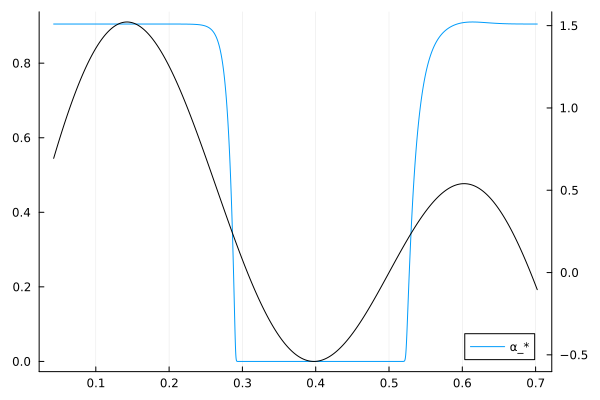

In [61]:
plot(Ω,phi.(results.minimizer),label="α_*")
plot!(twinx(),Ω,V.(Ω),label="",color=:black)

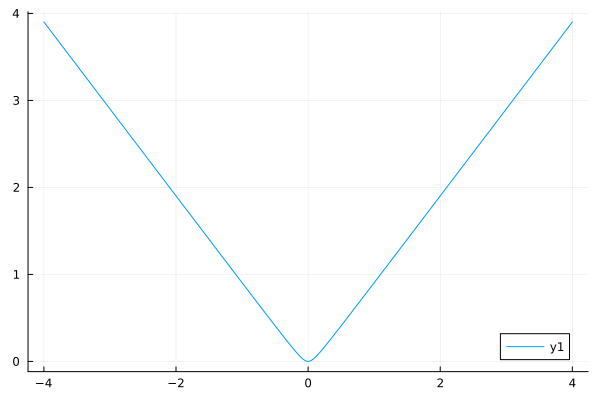

In [62]:
plot(phi,-4,4)